In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
from datetime import datetime, timedelta
from ipywidgets import interact
# from datetime import datetime as dt, time, timedelta

In [2]:
import sys
from os.path import join
import re
import cv2

In [3]:
# REMI STUFF
#sys.path.insert(0,'/Users/megret/Documents/Research/BeeTracking/Soft/labelbeeconvert')
#sys.path.insert(0,'/Users/megret/Documents/Research/BeeTracking/Soft/apriltag/swatbotics-apriltag/python/')
#sys.path.insert(0,'/mnt/storage/work/rmegret/labelbeeconvert')
#from labelbeeconvert import labelbee_convert as lb
#from beevideoutil import video as bv
from plotbee.beevideoutil import labelbee_convert as lb
from plotbee.beevideoutil import video as bv

/home/jchan/beepose/plotbee/plotbee/beevideoutil/labelbee_convert.py:277: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from tqdm.notebook import tqdm
# Test
for i in tqdm(range(50)):
    pass

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
def get_video_date(filename):
    pattern  = r"C(?P<colony>[0-9][0-9])_(?P<year>[0-9][0-9])(?P<month>[0-9][0-9])(?P<day>[0-9][0-9])(?P<hour>[0-9][0-9])(?P<min>[0-9][0-9])(?P<sec>[0-9][0-9])"
    pattern = re.compile(pattern)
    m = pattern.search(filename)
    date_format = ["year", "month", "day", "hour", "min", "sec"]

    YY,MM,DD,hh,mm,ss=[int(m.group(g)) for g in date_format]
    return datetime(2000+YY,MM,DD,hh,mm,ss)

def one_hot_encoding(df, columns=[]):
    cdf = df.copy()
    if isinstance(columns, list):
        for c in columns:
            cdf = one_hot_encode_column(cdf, c)
    elif isinstance(columns, str):
        cdf = one_hot_encode_column(cdf, columns)
    return cdf
  
def one_hot_encode_column(df, column):
    categories = df[column].dropna().unique()
    for cat in categories:
        df[cat] = (df[column] == cat)
    return df

def load_track_df(filename):
    track_df = pd.read_csv(filename)
    starttime = get_video_date(filename)
    track_df["datetime"] = track_df.apply(lambda x: starttime + timedelta(seconds=x["track_startframe"]/20), axis=1)
    track_df["track_starttime"] = track_df.apply(lambda x: starttime + timedelta(seconds=x["track_startframe"]/20), axis=1)
    track_df["track_endtime"] = track_df.apply(lambda x: starttime + timedelta(seconds=x["track_endframe"]/20), axis=1)
    track_df["pollen"] = track_df["track_pollen_score"] > 0.5
    track_df = one_hot_encoding(track_df, columns=["track_event"])
    return track_df

def get_options(tid):
    options = list()
    for i, row in vdf[vdf.track_tagid == tid].iterrows():
        noise, name = event_name(row)
#         if not noise:
        options.append((name, dict(row)))
    return options

def event_name(row):
    noise = False
    event_name = ""
    if row.pollen:
        event_name += "pollen"
    if row.entering:
        event_name += "entering"
    if row.leaving:
        event_name += "leaving"
    if row.walking:
        event_name += "walking"
    if row.entering_leaving:
        event_name += "entering_leaving"
    if event_name == "":
        event_name += "noise"
        noise = True
        
    event_name += " - {}".format(row.datetime)
    return noise, event_name

def load_frame(video, frame):
    cap = cv2.VideoCapture(video)
    cap.set(1, frame)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame


def plot_line(frame, p1, p2, color=[255, 0, 0], thickness=7):
    frame = cv2.line(frame, p1, p2, color, thickness)
    return frame

def plot_track(row):
    
    frame = load_frame(row["video_name"], row["track_startframe"])
    start_x = row["track_startx"] 
    start_y = row["track_starty"]
    
    end_x = row["track_endx"]
    end_y = row["track_endy"]
    
    p1 = (start_x, start_y)
    p2 = (end_x, end_y)
    
    plt.imshow(plot_line(frame, p1, p2))

In [7]:
files = glob.glob("/mnt/storage/work/jchan/final_beepose/one_week_analysis_800/analysis_tracks*")
files = sorted(files)
track_dfs = list()
for i, file in enumerate(files):
    track_df = load_track_df(file)
    track_df["video_id"] = i
    track_dfs.append(track_df)
    
full_df = pd.concat(track_dfs)

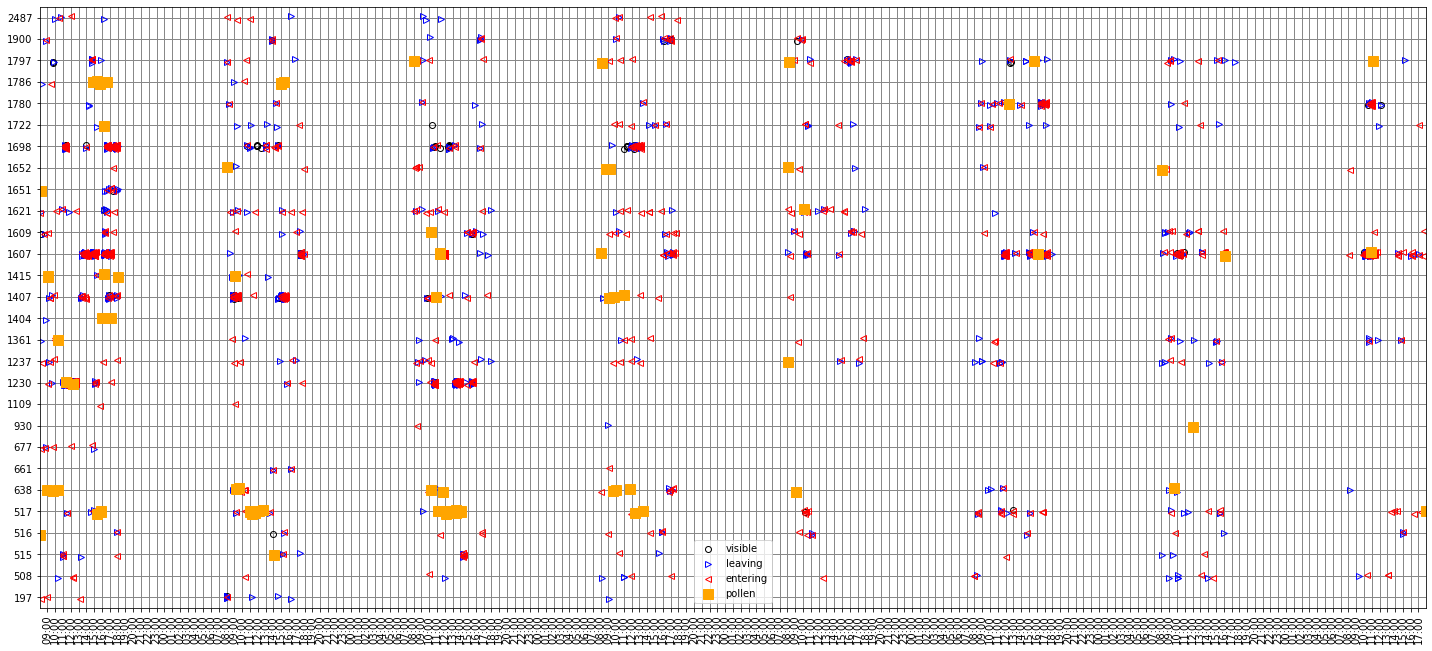

In [8]:
import matplotlib.dates as mdates
from datetime import datetime as dt

vdf = full_df[full_df.groupby('track_tagid').track_tagid.transform('size')>5]

tids = vdf.track_tagid.unique()
tids = np.sort(np.unique(tids)).astype(int)

vdf =full_df[full_df.track_tagid.isin(tids)]

#gdf2=gdf[gdf.tagid.isin([1230,508])]

fig,axes = plt.subplots(1,1,figsize=(20,10))
plt.sca(axes)
lb.plot_activities_df(vdf, plot_interval=True, tagids=tids);
#lb.plot_activities_df(df2, plot_interval=False);
plt.tight_layout();

ax=plt.gca()
hours = mdates.HourLocator() 
hourFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hourFmt)
#ax.set_xlim(dt(2017,6,21,13),dt(2017,6,21,14))
plt.savefig("tagged_bees_activities.png")

In [9]:
from ipywidgets import *
VIDEO_FORMAT = "/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_%y%m%d%H0000.mp4"
vdf.loc[:, "video_name"] = vdf.datetime.apply(lambda x: x.strftime(VIDEO_FORMAT))

/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [16]:
tids_widget = Dropdown(options = tids)
options = get_options(tids_widget.value)
events_widget = Dropdown(options=options)

def update_events(change):
    ctid = change.new
    options = get_options(ctid)
    events_widget.options = options
    
tids_widget.observe(update_events, names="value")
plt.rcParams['figure.figsize'] = [20, 20]
def f(tid, event):
    plot_track(event)
    
interact(f, tid=tids_widget, event=events_widget);

interactive(children=(Dropdown(description='tid', options=(197, 508, 515, 516, 517, 638, 661, 677, 930, 1109, …